##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 사용자 정의 학습: 자세히 둘러보기

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/customization/custom_training_walkthrough.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/customization/custom_training_walkthrough.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/customization/custom_training_walkthrough.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

이번 튜토리얼에서는 머신러닝을 이용해 붓꽃의 품종을 *분류*해 보도록 하겠습니다. TensorFlow를 사용하여 다음을 실행할 수 있습니다.

1. 모델 구축
2. 모델 훈련
3. 모델을 사용한 예측

##  TensorFlow 프로그래밍

이번 튜토리얼에서는 다음과 같은 고수준 TensorFlow 개념을 사용합니다.

- TensorFlow의 [즉시 실행](https://www.tensorflow.org/guide/eager) 기본 개발 환경 사용
- [데이터세트 API](https://www.tensorflow.org/guide/datasets)를 활용한 데이터 가져오기
- TensorFlow의 [케라스 API](https://keras.io/getting-started/sequential-model-guide/)를 활용하여 모델 및 레이어 구축

이번 튜토리얼은 다음과 같이 기타 TensorFlow 프로그램과 유사하게 구성됩니다.

1. 데이터 가져오기 및 분석.
2. 모델 타입 선정.
3. 모델 훈련.
4. 모델 효과 평가.
5. 훈련된 모델을 사용하여 예측하기

## 프로그램 설정

### 라이브러리 임포트

TensorFlow 및 기타 필요한 Python 모듈을 가져옵니다. TensorFlow는 기본적으로 [즉시 실행](https://www.tensorflow.org/guide/eager)을 사용하여 나중에 실행되는 계산 그래프를 생성하는 대신 연산을 즉시 평가하고 구체적인 값을 반환합니다. REPL이나 `python` 대화형 콘솔을 사용한다면 익숙할 것입니다.

In [2]:
import os
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf

In [4]:
print("텐서플로 버전: {}".format(tf.__version__))
print("즉시 실행: {}".format(tf.executing_eagerly()))

텐서플로 버전: 2.3.0-rc0
즉시 실행: True


## 붓꽃 분류 문제

만약 식물학자가 붓꽃을 자동으로 분류하는 방법을 찾고 있다고 가정해 봅시다. 머신러닝은 통계적으로 꽃을 분류할 수 있는 다양한 알고리즘을 제공합니다. 예를 들어, 정교한 머신러닝 프로그램이라면 사진을 통해 꽃을 분류할 수 있을 겁니다. 하지만 이번 튜토리얼에서는 [꽃받침](https://en.wikipedia.org/wiki/Sepal)과 [꽃잎](https://en.wikipedia.org/wiki/Petal)에서 측정된 길이와 폭의 값에 기반해서 붓꽃을 분류해 보도록 하겠습니다.

이 붓꽃은 그 종류가 약 300종에 이르지만, 튜토리얼에서는 다음의 3가지 품종으로만 분류해 보겠습니다.

- Iris setosa
- Iris virginica
- Iris versicolor

<table>
  <tr><td>     <img src="https://www.tensorflow.org/images/iris_three_species.jpg" alt="Petal geometry compared for three iris species: Iris setosa, Iris virginica, and Iris versicolor">   </td></tr>
  <tr><td align="center">     <b>그림 1.</b> <a href="https://commons.wikimedia.org/w/index.php?curid=170298">Iris setosa</a> (<a href="https://commons.wikimedia.org/wiki/User:Radomil">Radomil</a>, CC BY-SA 3.0), <a href="https://commons.wikimedia.org/w/index.php?curid=248095">Iris versicolor{</a>, (<a href="https://commons.wikimedia.org/wiki/User:Dlanglois">Dlanglois</a>, CC BY-SA 3.0), <a href="https://www.flickr.com/photos/33397993@N05/3352169862">Iris virginica</a> (<a href="https://www.flickr.com/photos/33397993@N05">Frank Mayfield</a>, CC BY-SA 2.0).<br>
</td></tr>
</table>

다행히도 꽃받침과 꽃잎의 길이와 폭의 값을 측정한 [120개의 붓꽃 데이터](https://en.wikipedia.org/wiki/Iris_flower_data_set)가 있습니다. 해당 데이터는 머신러닝 분류 문제에 있어 초보자에게 유명한 고전적인 데이터세트입니다.

## 훈련 데이터 가져오기 및 파싱

데이터 파일을 다운로드하여 이 Python 프로그램이 사용할 수 있는 구조로 해당 데이터를 전환합니다.

### 데이터세트 다운로드

`tf.keras.utils.get_file` 함수를 사용하여 훈련 데이터세트를 다운로드합니다. 이 함수는 다운로드된 파일 경로를 반환합니다.

In [11]:
# train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"
train_dataset_url = "file:///root/tensorflow-tutorials/utils/datasets/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

8192/2194 [================================================================================================================] - 0s 0us/step
Local copy of the dataset file: /root/.keras/datasets/iris_training.csv


### 데이터 탐색

이 데이터세트 `iris_training.csv`는 텍스트 파일이며, 표로 된 데이터를 CSV(comma-separated values)로 저장합니다. `head -n5` 명령을 사용하여 처음 5개 항목을 확인합니다.

In [12]:
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


해당 데이터세트에서 다음 사항에 주목하세요.

1. 첫 번째 줄은 데이터세트 정보를 포함하는 헤더입니다.

- 총 120개의 샘플이 있으며, 각 샘플에는 4개의 특성과 3개의 가능한 라벨 이름 중 하나가 있습니다.

1. 다음 줄은 데이터 레코드로, 한 줄당 한 개의 *[예](https://developers.google.com/machine-learning/glossary/#example)*가 있습니다.

- 처음 4개의 필드는 *[특성](https://developers.google.com/machine-learning/glossary/#feature)*으로, 예의 특징을 보여줍니다. 여기서 필드는 붓꽃의 측정값을 부동소수점으로 표시합니다.
- 마지막 열은 *[라벨](https://developers.google.com/machine-learning/glossary/#label)*이며 예측하려는 값을 나타냅니다. 이 데이터세트에서는 꽃의 이름에 상응하는 정수값 0, 1, 2를 나타냅니다.

코드로 표현하면 다음과 같습니다.:

In [13]:
# CSV 파일안에서 컬럼의 순서
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("특성: {}".format(feature_names))
print("레이블: {}".format(label_name))

특성: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
레이블: species


각 라벨은 'setosa'와 같은 문자형 이름과 관련이 있습니다. 하지만 머신러닝은 주로 숫자형 값에 의존합니다. 라벨 숫자는 다음의 이름을 대신합니다.

- `0`: Iris setosa
- `1`: Iris versicolor
- `2`: Iris virginica

특성과 라벨에 관한 더 자세한 내용은 [머신러닝 단기 집중 과정의 ML 용어 섹션](https://developers.google.com/machine-learning/crash-course/framing/ml-terminology)을 참조하세요.

In [14]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

### `tf.data.Dataset` 생성

TensorFlow의 [데이터세트 API](https://www.tensorflow.org/guide/datasets)는 모델로 데이터를 로드할 때 일반적으로 발생하는 다양한 사례를 다룹니다. 이는 데이터를 읽고 훈련에 필요한 형태로 변환하는 고수준 API입니다.

데이터세트는 CSV 형식의 텍스트 파일이므로, 적절한 형태로 데이터를 구분하기 위해 `tf.data.experimental.make_csv_dataset` 함수를 사용하겠습니다. 이 함수는 훈련 모델용 데이터를 생성하므로, 초기값은 데이터 (`shuffle=True, shuffle_buffer_size=10000`)의 셔플링 및 데이터세트(`num_epochs=None`)의 무한 반복으로 설정되어있습니다. 또한 [batch_size](https://developers.google.com/machine-learning/glossary/#batch_size) 파라미터를 다음과 같이 설정합니다.

In [15]:
batch_size = 32

train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

`make_csv_dataset` 함수는 `(features, label)` 쌍에서 `tf.data.Dataset`를 반환하며, 여기서 `features`는 `{'feature_name': value}` 사전에 해당합니다.

이러한 `Dataset` 객체는 반복 가능합니다. 다음을 통해 배치별 특성을 살펴보겠습니다.

In [16]:
features, labels = next(iter(train_dataset))

print(features)

OrderedDict([('sepal_length', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([4.9, 6.1, 5.7, 5.6, 5.1, 6.1, 4.8, 5. , 5. , 6.3, 6.1, 4.4, 6.2,
       6. , 5.1, 6.3, 7.7, 5.4, 5.6, 5.1, 5. , 7.7, 4.9, 6.3, 6.4, 4.6,
       5.8, 4.6, 6.3, 6. , 5.9, 6.3], dtype=float32)>), ('sepal_width', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([3.1, 2.6, 2.8, 2.7, 3.8, 2.8, 3.1, 3.5, 3.4, 2.7, 2.9, 2.9, 2.2,
       2.7, 3.7, 3.4, 3.8, 3. , 2.9, 3.8, 3. , 2.8, 3. , 3.3, 3.1, 3.1,
       2.7, 3.4, 2.5, 3. , 3.2, 3.3], dtype=float32)>), ('petal_length', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([1.5, 5.6, 4.5, 4.2, 1.6, 4.7, 1.6, 1.3, 1.5, 4.9, 4.7, 1.4, 4.5,
       5.1, 1.5, 5.6, 6.7, 4.5, 3.6, 1.5, 1.6, 6.7, 1.4, 6. , 5.5, 1.5,
       5.1, 1.4, 5. , 4.8, 4.8, 4.7], dtype=float32)>), ('petal_width', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([0.1, 1.4, 1.3, 1.3, 0.2, 1.2, 0.2, 0.3, 0.2, 1.8, 1.4, 0.2, 1.5,
       1.6, 0.4, 2.4, 2.2, 1.5, 1.3, 0.3, 0.2, 2. , 0.2, 2.5,

유사한 특성은 하나의 그룹으로 묶이거나 *배치 처리*된다는 점에 주목하세요. 각 예제 행의 필드는 해당하는 특성 배열에 추가됩니다. `batch_size`를 조정하여 이러한 특성 배열에 저장된 샘플 수를 설정하세요.

또한 배치에서 일부 특성을 플롯하여 클러스터가 생기는 것을 확인할 수 있습니다.

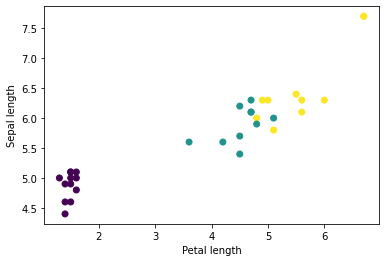

In [17]:
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

모델 구축 단계를 단순화하기 위해, 특성 사전을 `(batch_size, num_features)`의 형상을 갖는 단일 배열로 리패키징하는 함수를 생성합니다.

이 함수는 [tf.stack](https://www.tensorflow.org/api_docs/python/tf/stack) 메서드를 사용하여 텐서의 목록에서 값을 취하고 지정된 차원에서 결합된 텐서를 생성합니다.

In [18]:
def pack_features_vector(features, labels):
  """특성들을 단일 배열로 묶습니다."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

그런 다음 [tf.data.Dataset.map](https://www.tensorflow.org/api_docs/python/tf/data/dataset/map) 메서드를 사용하여 각 `(features,label)` 쌍의 `features`을 훈련 데이터세트에 저장합니다.

In [19]:
train_dataset = train_dataset.map(pack_features_vector)

`Dataset`의 특성 요소는 `(batch_size, num_features)` 형상의 배열이 되었습니다. 예제의 앞부분을 살펴봅시다.

In [20]:
features, labels = next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[5.7 3.  4.2 1.2]
 [6.3 2.7 4.9 1.8]
 [5.1 3.8 1.6 0.2]
 [5.4 3.9 1.7 0.4]
 [7.2 3.6 6.1 2.5]], shape=(5, 4), dtype=float32)


## 모델 타입 선정

### 왜 모델을 사용해야하는가?

*[모델](https://developers.google.com/machine-learning/crash-course/glossary#model)*은 특성과 레이블 간의 관계입니다. 붓꽃 분류 문제의 경우, 모델은 꽃받침과 꽃잎 측정치와 예측된 붓꽃 종 간의 관계를 정의합니다. 일부 간단한 모델은 몇 줄의 대수로 설명할 수 있지만, 복잡한 머신러닝 모델에는 요약하기 어려운 매개변수가 많습니다.

머신러닝을 사용하지 *않고* 4가지 특성과 붓꽃 종 간의 관계를 확인할 수 있을까요? 즉, 기존 프로그래밍 기술(예: 여러 개의 조건문)을 사용하여 모델을 만들 수 있을까요? 특정 종에 대한 꽃잎과 꽃받침 측정치 간의 관계를 확인할 수 있을 만큼 충분히 오랫동안 데이터세트를 분석한 경우 가능할 수도 있습니다. 그러나 이것은 더 복잡한 데이터세트에서는 어렵거나 불가능할 수도 있습니다. 좋은 머신러닝 접근 방식이라면 적절한 모델을 제시해 줍니다. 적절한 머신러닝 모델 형식에 충분한 대표 예제를 제공하면 프로그램이 관계를 파악해 줍니다.

### 모델 선정

훈련할 모델의 종류를 선택해야 합니다. 많은 형식의 모델이 있으며 좋은 모델을 선택하려면 경험이 필요합니다. 이 튜토리얼에서는 신경망을 사용하여 붓꽃 분류 문제를 해결합니다. *[신경망](https://developers.google.com/machine-learning/glossary/#neural_network)*은 특성과 레이블 간의 복잡한 관계를 찾을 수 있으며, 하나 이상의 숨겨진 레이어로 구성된 고도로 구조화된 그래프입니다. 각 *[숨겨진 레이어](https://developers.google.com/machine-learning/glossary/#neural_network)*는 하나 이상의 *[신경](https://developers.google.com/machine-learning/glossary/#neuron)*으로 구성됩니다. 신경망에는 여러 범주가 있으며, 이 프로그램은 조밀하거나 *[완전히 연결된 신경망](https://developers.google.com/machine-learning/glossary/#neuron)*을 사용합니다. 즉, 한 레이어의 신경은 이전 레이어의 *모든* 신경에서 입력 연결을 받습니다. 예를 들어, 그림 2는 입력 레이어, 2개의 숨겨진 레이어 및 출력 레이어로 구성된 조밀한 신경망을 보여줍니다.

<table>
  <tr><td>     <img src="https://www.tensorflow.org/images/custom_estimators/full_network.png" alt="A diagram of the network architecture: Inputs, 2 hidden layers, and outputs">   </td></tr>
  <tr><td align="center">     <b>그림 2.</b> 특성, 숨겨진 레이어, 예측으로 구성된 신경망<br>
</td></tr>
</table>

그림 2의 모델을 훈련하고 레이블이 지정되지 않은 예제를 제공하면, 이 꽃이 주어진 붓꽃 종일 가능성에 대한 3가지 예측값이 생성됩니다. 이 예측을 *[추론](https://developers.google.com/machine-learning/crash-course/glossary#inference)*이라고 합니다. 이 예에서 출력 예측값의 합계는 1.0입니다. 그림 2에서 이 예측은 *Iris setosa*의 경우 `0.02`, *Iris versicolor*의 경우 `0.95`, *Iris virginica*의 경우 `0.03`입니다. 즉, 모델은 95% 확률로 레이블이 지정되지 않은 예시 꽃이 *Iris versicolor*라고 예측합니다.

### 케라스를 사용한 모델 생성

TensorFlow의 `tf.keras` API는 모델과 레이어를 생성하는 데 주로 사용됩니다. Keras가 모든 구성 요소 연결에 대한 복잡성을 처리해 주기 때문에 모델을 구축하고 실험하는 데 용이합니다.

`tf.keras.Sequential` 모델은 레이어의 선형 스택입니다. 이 생성자는 레이어 인스턴스 목록을 취하는데, 아래의 경우, 각 10개의 노드를 갖는 두 개의 `tf.keras.layers.Dense` 레이어 및 3개의 노드를 갖는 출력 레이어로 구성되어 레이블 예측을 보여주고 있습니다. 첫 번째 레이어의 `input_shape` 매개변수는 데이터세트의 특성 수에 해당하며 필수적입니다.

In [21]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # 입력 형태 필요
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

*[활성화 함수](https://developers.google.com/machine-learning/crash-course/glossary#activation_function)*는 각 레이어의 노드에서 출력 형상을 결정합니다. 이러한 비선형성이 중요한데, 활성화 함수가 없는 모델은 단일 레이어와 마찬가지이기 때문입니다. `tf.keras.activations`가 많이 있지만, 숨겨진 레이어에서는 주로 [ReLU](https://developers.google.com/machine-learning/crash-course/glossary#ReLU) 함수가 사용됩니다.

숨겨진 레이어와 신경의 이상적인 수는 문제와 데이터세트에 따라 다릅니다. 머신러닝의 여러 측면과 마찬가지로 신경망의 최상의 형태를 고르기 위해서는 지식과 실험이 모두 필요합니다. 경험상 숨겨진 레이어와 신경의 수를 늘리면 일반적으로 더 강력한 모델이 생성되며 이를 효과적으로 훈련하려면 더 많은 데이터가 필요합니다.

### 모델 사용

이 모델이 특성의 배치에 대해 수행하는 작업을 간단히 살펴봅시다.

In [22]:
predictions = model(features)
predictions[:5]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-0.47450268,  0.3852796 ,  3.2358608 ],
       [-0.33094236,  0.8739536 ,  3.4685397 ],
       [-1.1141187 ,  0.20361647,  2.8472753 ],
       [-1.1344578 ,  0.34782752,  2.9390776 ],
       [-0.4604224 ,  1.0085403 ,  4.0107875 ]], dtype=float32)>

여기에서 각 예제는 각 클래스에 대한 [로짓](https://developers.google.com/machine-learning/crash-course/glossary#logits)을 반환합니다.

이러한 로짓을 각 클래스의 확률로 변환하려면 [softmax](https://developers.google.com/machine-learning/crash-course/glossary#softmax) 함수를 사용하세요.

In [23]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.02260842, 0.0534157 , 0.9239759 ],
       [0.02040214, 0.06806996, 0.9115279 ],
       [0.01746254, 0.06522173, 0.9173157 ],
       [0.01558425, 0.0686174 , 0.9157984 ],
       [0.01077502, 0.04681452, 0.9424104 ]], dtype=float32)>

클래스에서 `tf.argmax`를 사용하면 예측된 클래스 인덱스가 제공됩니다. 그러나 모델은 아직 훈련되지 않았으므로 좋은 예측이 아닙니다.

In [24]:
print("  예측: {}".format(tf.argmax(predictions, axis=1)))
print("레이블: {}".format(labels))

  예측: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
레이블: [1 2 0 0 2 2 2 2 0 0 2 0 1 2 1 0 0 0 2 2 0 0 1 1 2 0 0 2 1 0 1 1]


## 모델 훈련하기

*[훈련하기](https://developers.google.com/machine-learning/crash-course/glossary#training)*는 모델이 점차 최적화될 때 또는 모델이 데이터세트를 학습하는 머신러닝 단계입니다. 이 단계의 목표는 훈련 데이터세트의 구조에 대해 충분히 학습하여 보이지 않는 데이터를 예측하는 것입니다. 훈련 데이터세트에 대해 너무 많이 배우면 예측이 관측한 데이터에 대해서만 작동하고 일반화할 수 없습니다. 이런 문제를 과대적합이라고 하며, 이는 문제를 해결하는 방법을 이해하는 대신 답을 암기하는 것과 같습니다.

붓꽃 분류 문제는 *[감독 머신러닝](https://developers.google.com/machine-learning/glossary/#supervised_machine_learning)*의 예입니다. 모델은 레이블이 포함된 예시로 훈련됩니다. 비감독 머신러닝에서 예시에는 레이블이 포함되지 않습니다. 대신 모델은 일반적으로 특성 사이에서 패턴을 찾습니다.

### 손실 함수와 그래디언트 함수 정의하기

훈련 및 평가 단계 모두 모델의 *[손실](https://developers.google.com/machine-learning/crash-course/glossary#loss)*을 계산해야 합니다. 이것은 모델의 예측이 원하는 레이블에서 얼마나 떨어져 있는지, 즉 모델의 성능이 얼마나 나쁜지를 측정합니다. 이 값을 최소화하거나 최적화하려고 합니다.

모델의 손실은 `tf.keras.losses.categorical_crossentropy` 함수를 사용해 계산합니다. 이 함수는 모델의 클래스 확률 예측과 원하는 레이블을 입력으로 받아 예의 평균 손실을 반환합니다.

In [25]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [26]:
def loss(model, x, y):
  y_ = model(x)

  return loss_object(y_true=y, y_pred=y_)


l = loss(model, features, labels)
print("손실 테스트: {}".format(l))

손실 테스트: 2.3327372074127197


모델을 최적화하기 위해 사용되는 *[그래디언트](https://developers.google.com/machine-learning/crash-course/glossary#gradient)*를 계산하기 위해 `tf.GradientTape` 컨텍스트를 사용합니다.

In [27]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

### 옵티마이저 생성

*[옵티마이저](https://developers.google.com/machine-learning/crash-course/glossary#optimizer)*는 계산된 그래디언트를 모델의 변수에 적용하여 `loss` 함수를 최소화합니다. 손실 함수를 곡면으로 생각해 보세요(그림 3 참조). 곡면을 걸어 다니면서 가장 낮은 지점을 찾으려고 하는 것입니다. 그래디언트는 가장 가파른 상승 방향을 가리키므로 반대 방향으로 이동하여 경사를 내려갑니다. 각 배치의 손실과 그래디언트를 반복적으로 계산하여 훈련 중에 모델을 조정합니다. 점차적으로 모델은 손실을 최소화하기 위해 가중치와 바이어스의 최상의 조합을 찾습니다. 손실이 낮을수록 모델의 예측값이 더 좋습니다.

<table>
  <tr><td>     <img src="https://cs231n.github.io/assets/nn3/opt1.gif" width="70%" alt="Optimization algorithms visualized over time in 3D space.">   </td></tr>
  <tr><td align="center">
<b>그림 3.</b> 3D 공간에서 시간에 걸쳐 시각화한 최적화 알고리즘.<br>(출처: <a href="http://cs231n.github.io/neural-networks-3/">Stanford class CS231n</a>, MIT License, 이미지 제공: <a href="https://twitter.com/alecrad">Alec Radford</a>)</td></tr>
</table>

TensorFlow에는 훈련에 사용할 수 있는 많은 최적화 알고리즘이 있습니다. 이 모델에서는 *[확률적 경사하강법](https://developers.google.com/machine-learning/crash-course/glossary#gradient_descent)*(SGD) 알고리즘을 구현하는 `tf.keras.optimizers.SGD`를 사용합니다. `learning_rate`는 경사 아래로 반복할 때마다 사용할 단계의 크기를 설정하는 *하이퍼 매개변수*로서, 더 나은 결과를 얻기 위해 주로 조정하게 됩니다.

옵티마이저를 다음과 같이 설정합니다.

In [28]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

이를 사용해 한 번의 최적화 단계를 계산하기 위해 사용합니다.

In [29]:
loss_value, grads = grad(model, features, labels)

print("단계: {}, 초기 손실: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("단계: {},      손실: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels).numpy()))

단계: 0, 초기 손실: 2.3327372074127197
단계: 1,      손실: 1.8876135349273682


### 훈련 루프

여기까지 모두 마쳤다면 모델을 훈련할 준비가 되었습니다! 훈련 루프는 더 나은 예측을 할 수 있도록 데이터세트 예제를 모델에 제공합니다. 다음 코드 블록은 이러한 훈련 단계를 설정합니다.

1. 각 *epoch* 반복. Epoch는 데이터세트를 통과시키는 횟수입니다.
2. 하나의 Epoch 내에서 *특성*(`x`)과 *레이블*(`y`)이 포함된 훈련 `Dataset`의 각 예를 반복합니다.
3. 예의 특성을 사용하여 예측을 수행하고 레이블과 비교합니다. 예측의 부정확성을 측정하고 이를 사용하여 모델의 손실 및 그래디언트를 계산합니다.
4. 모델의 변수를 업데이트하기 위해 `옵티마이저`를 사용합니다.
5. 시각화를 위해 몇가지 값들을 저장합니다.
6. 각 epoch에 대해 반복합니다.

`num_epochs` 변수는 데이터세트 모음을 반복하는 횟수입니다. 단순히 생각해도, 모델을 더 오래 훈련한다고 해서 더 나은 모델이 보장되는 것은 아닐 것입니다. `num_epochs`는 조정할 수 있는  *[하이퍼 매개변수](https://developers.google.com/machine-learning/glossary/#hyperparameter)*입니다. 적절한 횟수를 선택하는 것은 많은 경험과 직관을 필요로 합니다.

In [30]:
## 노트: 이 셀을 다시 실행하면 동일한 모델의 변수가 사용됩니다.

# 플롯팅을 위해 결과를 저장합니다.
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # 훈련 루프 - 32개 샘플의 배치를 사용합니다.
  for x, y in train_dataset:
    # 모델을 최적화합니다.
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # 진행 상황을 추적합니다.
    epoch_loss_avg(loss_value)  # 현재 배치 손실을 추가합니다.
    # 예측된 라벨과 실제 라벨을 비교합니다.
    epoch_accuracy(y, model(x))

  # 세대 종료
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 1.462, Accuracy: 29.167%
Epoch 050: Loss: 0.086, Accuracy: 96.667%
Epoch 100: Loss: 0.066, Accuracy: 98.333%
Epoch 150: Loss: 0.061, Accuracy: 98.333%
Epoch 200: Loss: 0.050, Accuracy: 98.333%


### 시간에 따른 손실함수 시각화

모델의 훈련 과정을 출력하는 것도 유용하지만, 훈련 과정을 직접 보는 것이 *더* 도움이 되기도 합니다. [텐서보드(TensorBoard)](https://www.tensorflow.org/tensorboard)는 TensorFlow에 함께 구성된 굉장히 유용한 시각화 도구입니다. 하지만 `matplotlib` 모듈을 사용하여 기본적인 차트를 생성할 수 있습니다.

이 도표를 해석하는 것은 여러 경험이 필요하지만, 결국 모델을 최적화하기 위해 *손실* 이 내려가고 *정확도* 가 올라가는 것을 원합니다.

/opt/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54252 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53356 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51221 missing 

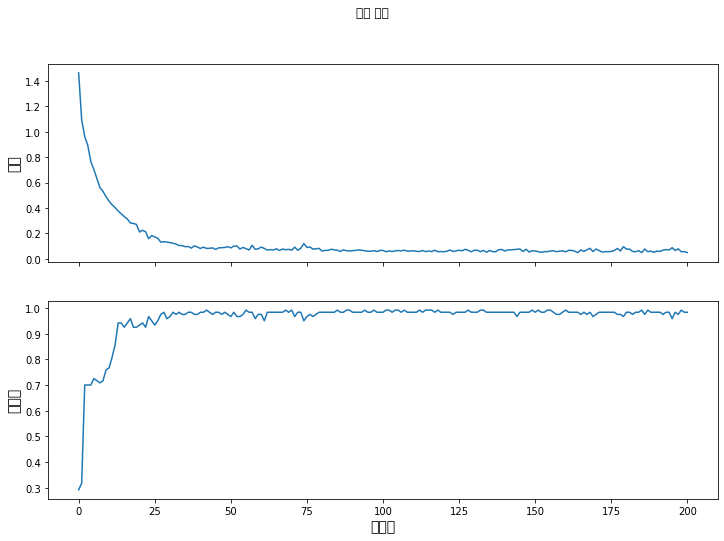

In [31]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('훈련 지표')

axes[0].set_ylabel("손실", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("정확도", fontsize=14)
axes[1].set_xlabel("에포크", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

## 모델 유효성 평가

이제 모델은 훈련되었습니다. 모델의 성능에 대한 몇가지 통계를 얻을 수 있습니다.

*평가*는 모델이 얼마나 효과적으로 예측을 수행하는지 알아보는 것을 의미합니다. 붓꽃 분류에서 모델의 효과를 확인하려면 꽃받침과 꽃잎 측정치를 모델에 전달하고 모델이 붓꽃 종을 예측하도록 요청합니다. 그런 다음 모델의 예측을 실제 레이블과 비교합니다. 예를 들어, 입력 예제의 절반에서 올바른 종을 선택한 모델의 *[정확성](https://developers.google.com/machine-learning/glossary/#accuracy)*은 `0.5`입니다. 그림 4는 약간 더 효과적인 모델을 보여줍니다. 5개 예측 중 4개는 80% 정확성으로 정확합니다.

<table cellpadding="8" border="0">
  <colgroup>
    <col span="4">
    <col span="1" bgcolor="lightblue">
    <col span="1" bgcolor="lightgreen">
  </colgroup>
  <tr bgcolor="lightgray">
    <th colspan="4">샘플 특성</th>
    <th colspan="1">레이블</th>
    <th colspan="1">모델 예측</th>
  </tr>
  <tr>
    <td>5.9</td>
<td>3.0</td>
<td>4.3</td>
<td>1.5</td>
<td align="center">1</td>
<td align="center">1</td>
  </tr>
  <tr>
    <td>6.9</td>
<td>3.1</td>
<td>5.4</td>
<td>2.1</td>
<td align="center">2</td>
<td align="center">2</td>
  </tr>
  <tr>
    <td>5.1</td>
<td>3.3</td>
<td>1.7</td>
<td>0.5</td>
<td align="center">0</td>
<td align="center">0</td>
  </tr>
  <tr>
    <td>6.0</td> <td>3.4</td> <td>4.5</td> <td>1.6</td> <td align="center">1</td>
<td align="center" bgcolor="red">2</td>
  </tr>
  <tr>
    <td>5.5</td>
<td>2.5</td>
<td>4.0</td>
<td>1.3</td>
<td align="center">1</td>
<td align="center">1</td>
  </tr>
  <tr><td align="center" colspan="6">
<b>그림 4.</b> 정확성 80%의 붓꽃 분류기<br>
</td></tr>
</table>

### 테스트 데이터 세트 설정

모델 평가는 모델 훈련과 유사합니다. 가장 큰 차이점은 예제가 훈련 세트가 아닌 별도의 *[테스트 세트](https://developers.google.com/machine-learning/crash-course/glossary#test_set)*에서 나온다는 것입니다. 모델의 효과를 공정하게 평가하려면 모델을 평가하는 데 사용되는 예가 모델 훈련에 사용된 예와 달라야 합니다.

테스트 `Dataset`를 설정하는 것은 훈련 `Dataset`를 설정하는 것과 유사합니다. CSV 텍스트 파일을 다운로드하고 값을 파싱한 후 약간의 셔플링을 합니다.

In [40]:
# test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"
test_url = "file:///root/tensorflow-tutorials/utils/datasets/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

In [41]:
test_dataset = tf.data.experimental.make_csv_dataset(
    test_fp,
    batch_size,
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

### 테스트 데이터 세트를 사용한 모델 평가

훈련 단계와 달리 모델은 테스트 데이터의 단일 [epoch](https://developers.google.com/machine-learning/glossary/#epoch)만 평가합니다. 다음 코드 셀에서 테스트 세트의 각 예제를 반복하고 모델의 예측값을 실제 레이블과 비교합니다. 이것은 전체 테스트 세트에서 모델의 정확성을 측정하는 데 사용됩니다.

In [42]:
test_accuracy = tf.keras.metrics.Accuracy()

for (x, y) in test_dataset:
  logits = model(x)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("테스트 세트 정확도: {:.3%}".format(test_accuracy.result()))

테스트 세트 정확도: 96.667%


마지막 배치에서 모델이 올바르게 예측한 것을 확인할 수 있습니다.

In [43]:
tf.stack([y,prediction],axis=1)

<tf.Tensor: shape=(30, 2), dtype=int32, numpy=
array([[1, 1],
       [2, 2],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [2, 2],
       [1, 1],
       [2, 2],
       [2, 2],
       [0, 0],
       [2, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1]], dtype=int32)>

## 훈련된 모델로 예측하기

모델을 훈련하고 이 모델이 붓꽃 종을 분류하는 데 훌륭함을 "증명"했지만 완벽하지는 않습니다. 이제 훈련된 모델을 사용하여 [레이블이 없는 예](https://developers.google.com/machine-learning/glossary/#unlabeled_example)에 대한 예측을 수행해 보겠습니다. 즉, 특성은 포함하지만 레이블은 포함하지 않는 예입니다.

실제로 레이블이 없는 예는 앱, CSV 파일, 데이터 피드 등 다양한 소스에서 제공될 수 있습니다. 지금은 레이블을 예측하기 위해 레이블이 없는 3가지 예를 수동으로 제공할 것입니다. 레이블 번호는 다음과 같이 표시됩니다.

- `0`: Iris setosa
- `1`: Iris versicolor
- `2`: Iris virginica

In [44]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("샘플 {} 예측: {} ({:4.1f}%)".format(i, name, 100*p))

샘플 0 예측: Iris setosa (99.9%)
샘플 1 예측: Iris versicolor (99.8%)
샘플 2 예측: Iris virginica (99.1%)
